# Optimizing Model Prediction

In this project we want to optimize a model step-by-step using various optimization methods. Our reference model will be a standard linear regression model, and our machine learning task will be to predict the extent of fire damage to a forest. Our data comes from the [Forest Fires](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage. 

## Required libraries and data exploration

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.nonparametric import smoothers_lowess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# load data
fires = pd.read_csv('fires.csv')

# Dataset information
print(fires.info())
print('\n')
print(fires.head())
print('\n')
print(fires.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB
None


   Unnamed: 0  X  Y month  day  FFMC   DMC     DC  ISI  temp    RH  wind  \
0           1  7  5   mar  fri  86.2  26.2   94.3  5.1   NaN  51.0   6.7   
1           2  7 

There is a considerable amount of missing data. Before we proceed with any model building or fitting, we will address the missing data first. Our general game plan is to impute any missing data via k-Nearest-Neighbor imputation. Then we will further look at the distributions of the given data and delete outliers. After checking some bivariate relationships, we will decide whether any data transformations are necessary. Eventually, we will keep the variables that we want to use for predictions and convert all columns to numeric datatypes, using dummy coding where necessary.

## Data imputation via KNN

In [2]:
# drop empty first column
fires = fires.drop('Unnamed: 0', axis=1)
print(fires.columns)

# convert months and days to numeric
months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
          'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
          'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

days = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4,
        'fri': 5, 'sat': 6, 'sun': 7}

fires['month'] = fires['month'].map(months)
fires['day'] = fires['day'].map(days)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')


In [3]:
# impute based on the 5 nearest neighbors
imp = KNNImputer(missing_values=np.nan, n_neighbors=5)
imputed_fires = pd.DataFrame(imp.fit_transform(fires), columns=fires.columns)

In [4]:
# check the results
print(imputed_fires.info())
print('\n')
print(imputed_fires.sample(n=10, axis=0, random_state=23))
print('\n')
print(imputed_fires.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    float64
 1   Y       517 non-null    float64
 2   month   517 non-null    float64
 3   day     517 non-null    float64
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    float64
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(13)
memory usage: 52.6 KB
None


       X    Y  month  day   FFMC    DMC     DC   ISI  temp    RH  wind  rain  \
156  2.0  4.0    9.0  6.0  93.40  145.4  721.4   8.1  28.6  27.0   2.2   0.0   
337  6.0  3.0    9.0  1.0  91.60  108.4  764.0   6.2  23.0  34.0   2.2   0.0   
161  6.0  4.0    8.0  4.0  92.74  131.7  578.8  10.

For now, that looks like an ok result. Let's plot each variables distribution and then check for outliers.

## Plotting the distributions

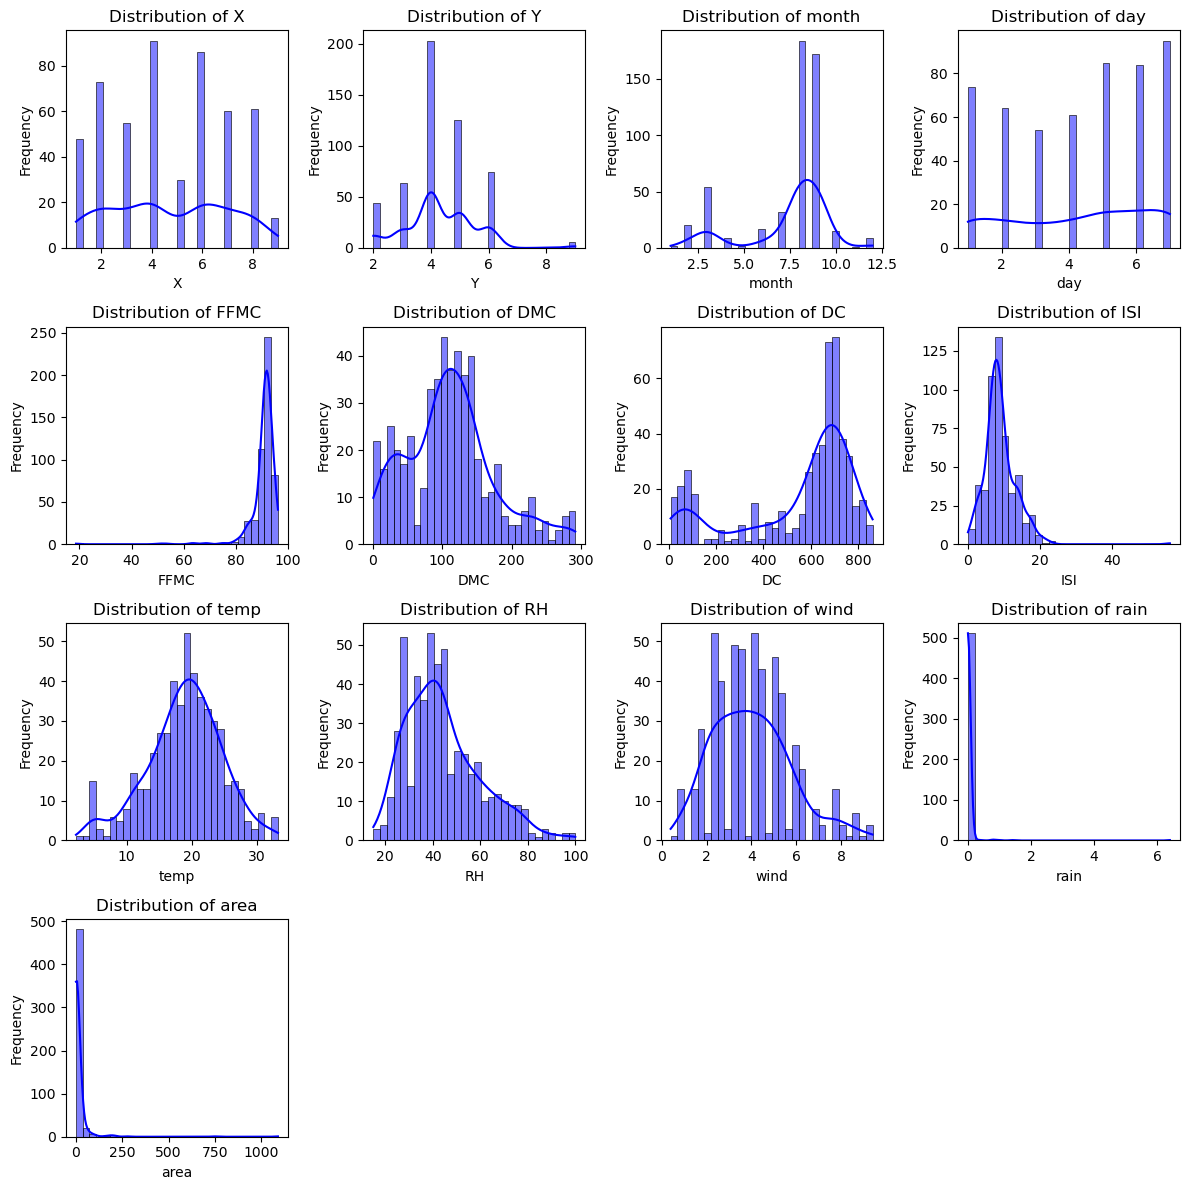

In [5]:
# plots for all variables
plt.figure(figsize=(12, 12))

for i, var in enumerate(imputed_fires.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(imputed_fires[var], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There is not a lot to say about the X and Y coordinates, since we don't know the original map layout that they are referring to. But fires tend to cluster in a particular Y coordinate (around 4) more than at other points in the distribution. With regard to the `month`variable, we see a high frequency of fires during the summer months (when it tends to be dryer and hotter) and some smaller peak during March. (It's not immediately clear, why we would observe fires at that time of the year). The `day`variable shows us that the probability of fires is higher on weekends rather than mid-week. This makes sense if we assume that fires might be sparked by people on camping trips happening on the wekends.
The `FFMC`variable seems tricky, as it is so strongly left-skewed. FFMC stands for "Fine Fuel Moisture Code" (according to [this](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) reference) and is a "numeric rating of the moisture content of litter and other cured fine fuels." Basically, this measures the igniteability of the area. Clearly, most fires when the surrounding is highly ignitable. But there are a few instances of fires occuring under low-igniteabilty conditions. The `DMC`variable is the "Duff Moisture Code" and basically measures the moisture content. Again, more instances of fires are observed at low moisture. According to the source, "The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers." Again, most fires occur at high levels of `DC`, but there is an accumulation of fires among low levels of `DC`as well. About the variable `ISI`we find: "The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It is based on wind speed and FFMC." The data seems to show that most fires have a rather slow initial spread, but as before we see a strong skew in the data with a long-tail towards very fast spreading fires.
As one would expect, fires are more likely to start when the outside temperature is higher, but in this case the mean outside temperature is about 19 degrees Celsius. We also find a cluster of fires breaking out at low temperatures. `RH`indicates the relative humidity, with fires being more likely at low humidity levels. We also observe fires more often at moderate wind speeds.
The `rain`and the `area`variables are very highly skewed. Most fires happen when there is very little rain, but very few fires also happen when there seems to be a lot of rain. The area of fires is typically (and luckily) small, but we also have instances where a large area is affected.

Let's illustrate the outliers further by loking at some boxplots.

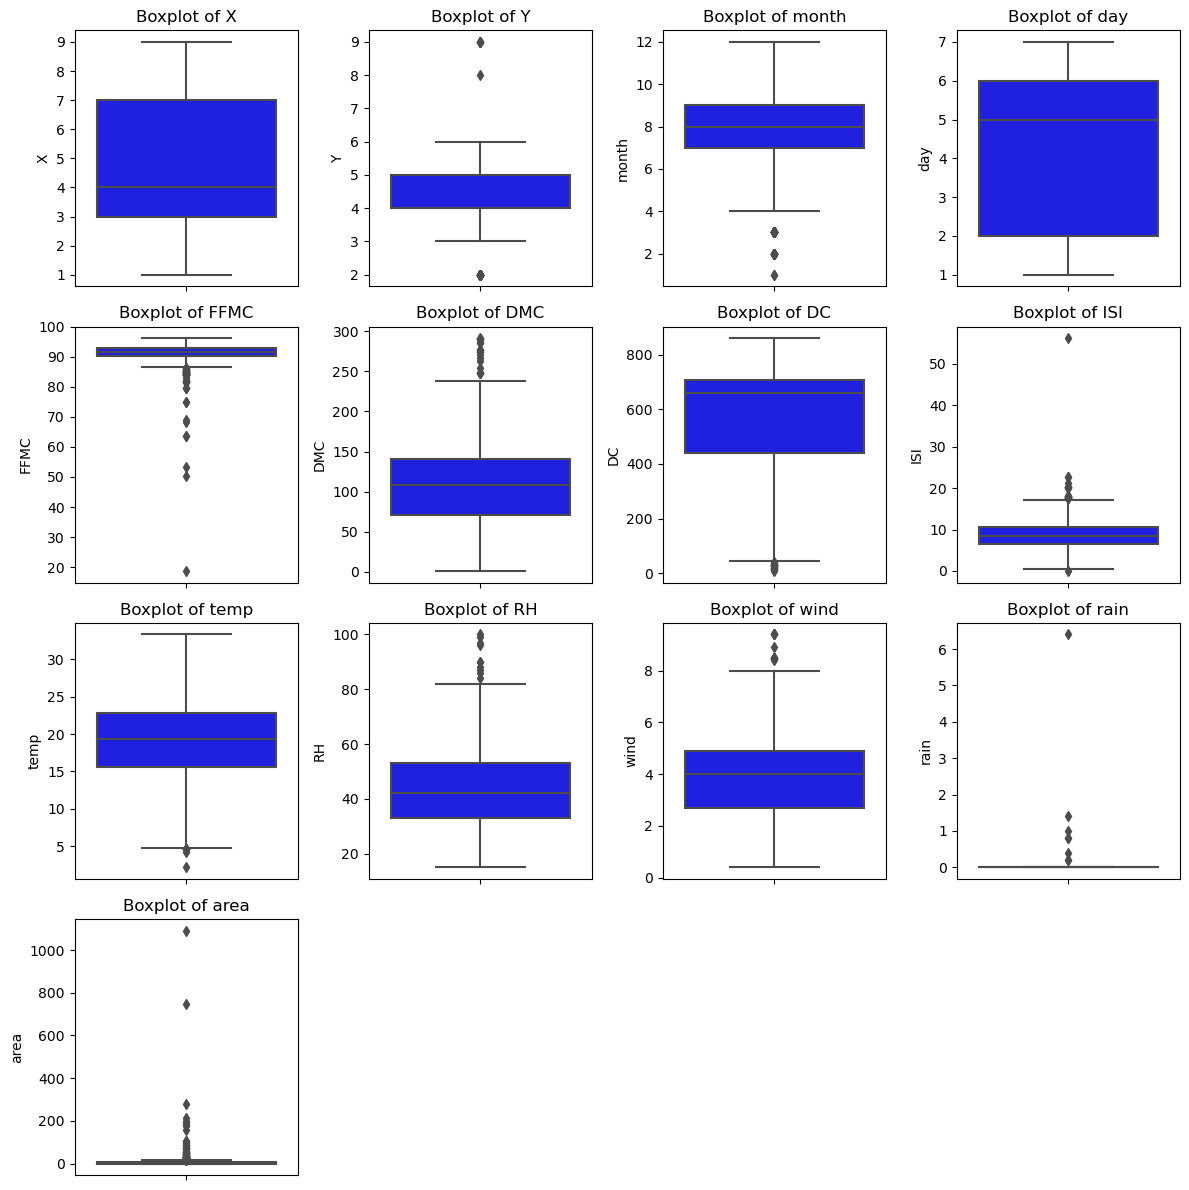

In [6]:
# boxplots for all variables
plt.figure(figsize=(12, 12))

for i, var in enumerate(imputed_fires.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=imputed_fires, y=var, color='blue')
    plt.title(f'Boxplot of {var}', fontsize=12)
    plt.xlabel('') 
    plt.ylabel(var)

plt.tight_layout()
plt.show()

It's clear that we have some variables with extreme outliers: `FFMC`, `ISI`, `rain`, and our outcome of interest, `area`. Considerate skewness is still observed for `DMC`and `RH`. The easiest would be to just delete these outlying observations. But a couterargument would be that those extreme instances might actually reveal important information. Maybe these are instances of arson? So rather than deleting the outliers, we choose the following strategy: We apply a Box-Cox-Transformation to these variables and check if the distribution can be corrected. For cases, where we still observe extreme outliers, we will delete them.

## Data transformations

In [7]:
# create a copy of imputed_fires
transformed_fires = imputed_fires.copy()

# Box-Cox-Transformation
for col in ['FFMC', 'DMC', 'RH', 'ISI', 'rain', 'area']:
    if (transformed_fires[col] <= 0).any():
        # shift values by adding a small constant if x <= 0
        transformed_fires[col] = transformed_fires[col] + 1

    # apply Box-Cox transformation
    transformed_fires[col], _ = boxcox(transformed_fires[col])

We check the distributions and boxplots.

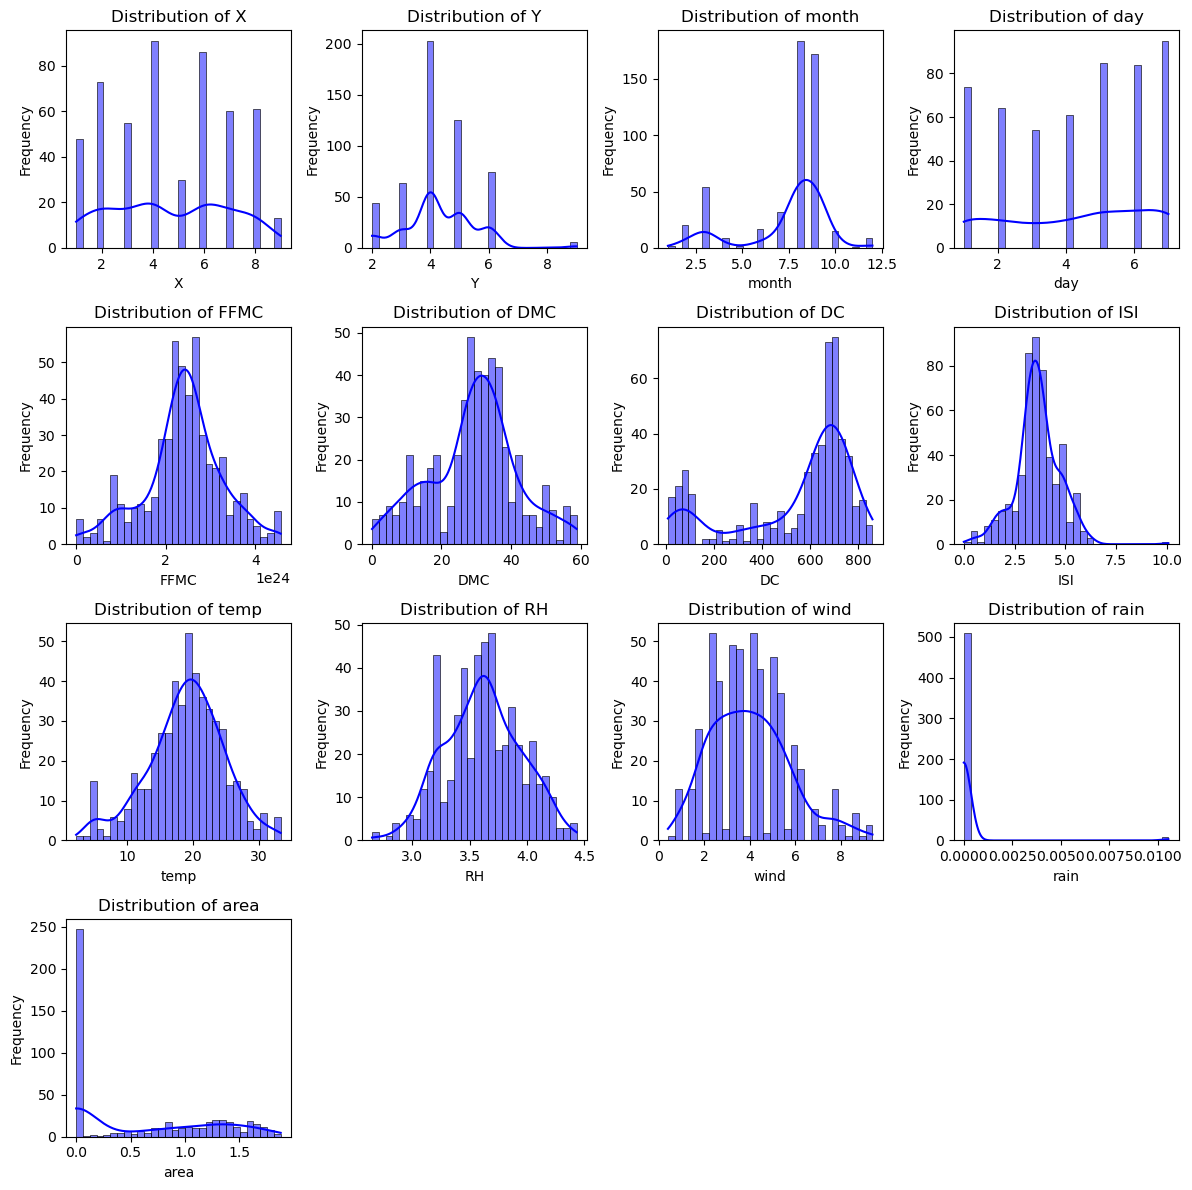

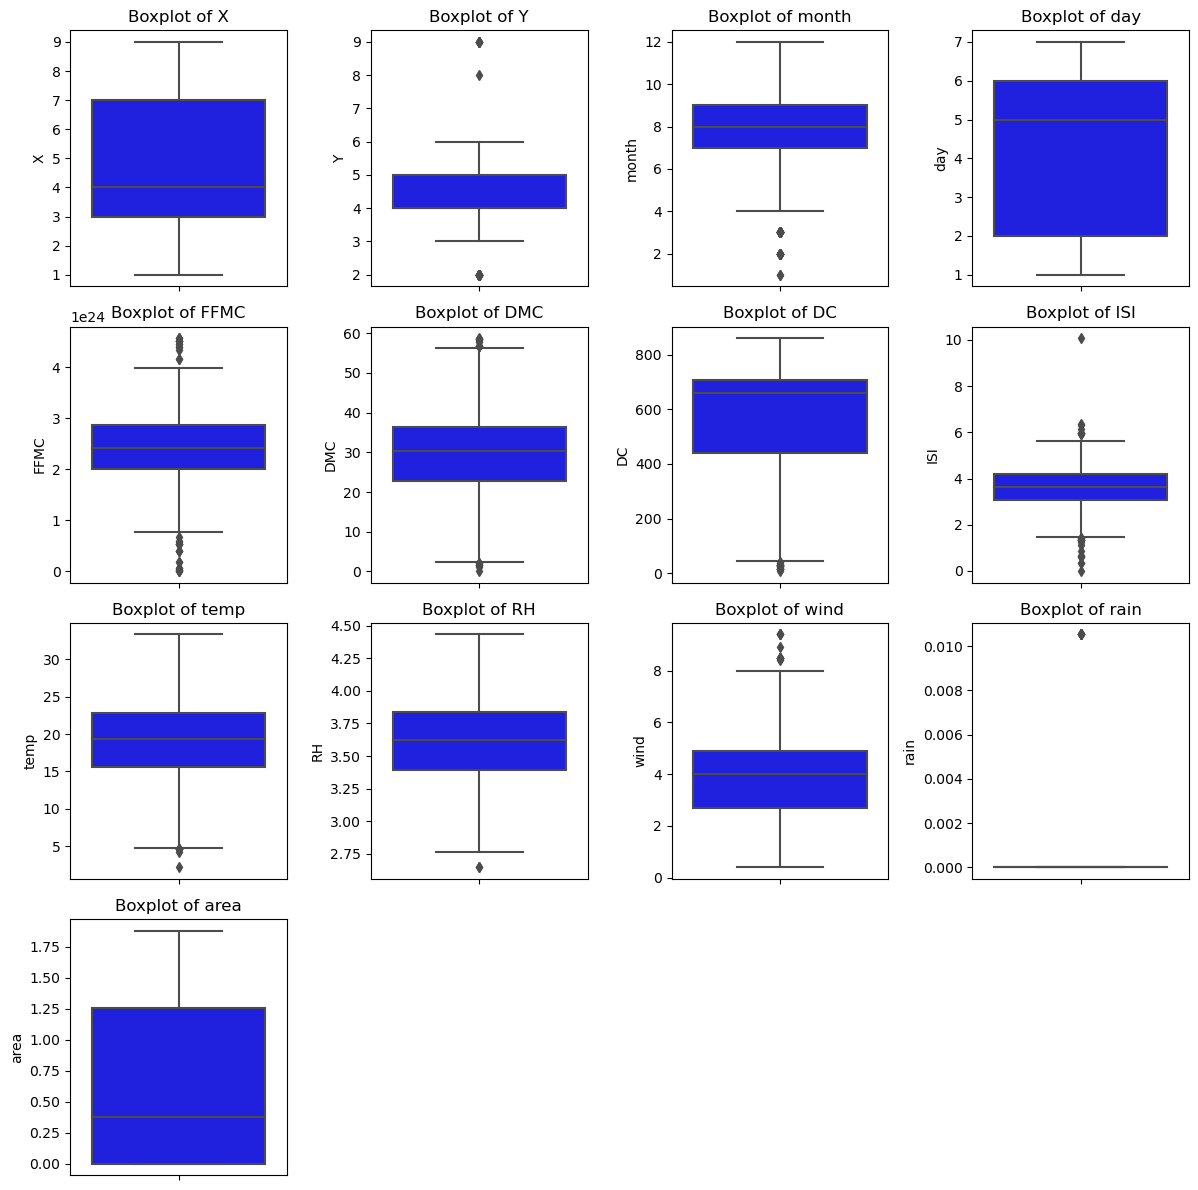

In [8]:
# check distributions
plt.figure(figsize=(12, 12))

for i, var in enumerate(transformed_fires.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(transformed_fires[var], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# check boxplots
plt.figure(figsize=(12, 12))

for i, var in enumerate(transformed_fires.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=transformed_fires, y=var, color='blue')
    plt.title(f'Boxplot of {var}', fontsize=12)
    plt.xlabel('')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

The situation has improved, but the `rain`variable is still too skewed for our purpose. Since rain is a rather rare occurence, we will binarize this variable, and just assign a value of 1 if there is any rain at all and 0 for all other cases.

In [9]:
# binarize rain variable
transformed_fires['rain'] = np.where(transformed_fires['rain'] > 0, 1, 0)

Before we are ready to move on, let's code the variables `month` and `day` as dummies and z-standardize all continuous features.

In [10]:
# recoding categorical columns using the OneHotEncoder
df_col_trans = make_column_transformer(
        (OneHotEncoder(), ['month', 'day']),
        remainder = "passthrough",
        verbose_feature_names_out = False)

onehot_df = df_col_trans.fit_transform(transformed_fires)

onehot_df = pd.DataFrame(onehot_df,
            columns = df_col_trans.get_feature_names_out())

print(onehot_df.head())

   month_1.0  month_2.0  month_3.0  month_4.0  month_5.0  month_6.0  \
0        0.0        0.0        1.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        1.0        0.0        0.0        0.0   
4        0.0        0.0        1.0        0.0        0.0        0.0   

   month_7.0  month_8.0  month_9.0  month_10.0  ...    Y          FFMC  \
0        0.0        0.0        0.0         0.0  ...  5.0  1.096407e+24   
1        0.0        0.0        0.0         1.0  ...  4.0  2.093904e+24   
2        0.0        0.0        0.0         1.0  ...  4.0  2.093904e+24   
3        0.0        0.0        0.0         0.0  ...  6.0  2.449461e+24   
4        0.0        0.0        0.0         0.0  ...  6.0  1.735340e+24   

         DMC      DC       ISI   temp        RH  wind  rain  area  
0  11.197187   94.30  2.649101  15.54  3.805259  6.70   0.0 

In [11]:
# assigning categorical and numerical vars
cat_vars = [f"month_{i}.0" for i in range(1, 13)] + [f"day_{i}.0" for i in range(1, 8)] + ["rain"]
num_vars = [col for col in onehot_df.columns if col not in cat_vars]

# splitting into a feature dataset and outcome dataset
area = onehot_df['area']
cont_features = onehot_df.drop(columns=cat_vars + ['area'])
cat_features = onehot_df[cat_vars]

# Z-standardize continuous features
def scale_features(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

# Scaling continuous features
scaled_cont = scale_features(cont_features)

# Concatenating scaled continuous features, categorical features, and 'area'
scaled_fires = pd.concat([scaled_cont, cat_features, area], axis=1)

print(scaled_fires.head())

          X         Y      FFMC       DMC        DC       ISI      temp  \
0  1.008313  0.569860 -1.500810 -1.458816 -1.853969 -0.900290 -0.589572   
1  1.008313 -0.244001 -0.352040 -0.130124  0.496043 -0.440745 -0.158933   
2  1.008313 -0.244001 -0.352040 -1.059172  0.042803 -0.440745 -0.754125   
3  1.440925  1.383722  0.057437 -1.287822 -1.922654  0.128318 -1.856982   
4  1.440925  1.383722 -0.764982 -0.904230 -1.821671  0.263469 -1.314307   

         RH      wind  month_1.0  ...  month_12.0  day_1.0  day_2.0  day_3.0  \
0  0.578078  1.525250        0.0  ...         0.0      0.0      0.0      0.0   
1 -0.662420 -1.772379        0.0  ...         0.0      0.0      1.0      0.0   
2 -0.662420 -1.544957        0.0  ...         0.0      0.0      0.0      0.0   
3  2.393618 -0.009854        0.0  ...         0.0      0.0      0.0      0.0   
4  2.450935  0.263054        0.0  ...         0.0      0.0      0.0      0.0   

   day_4.0  day_5.0  day_6.0  day_7.0  rain  area  
0      0.0      

## Plotting bivariate patterns

Let's plot the bivariate relationships between all features and the outcome. We can then refine further, which features look promising, which should be groupe, and which we need to consider any further.

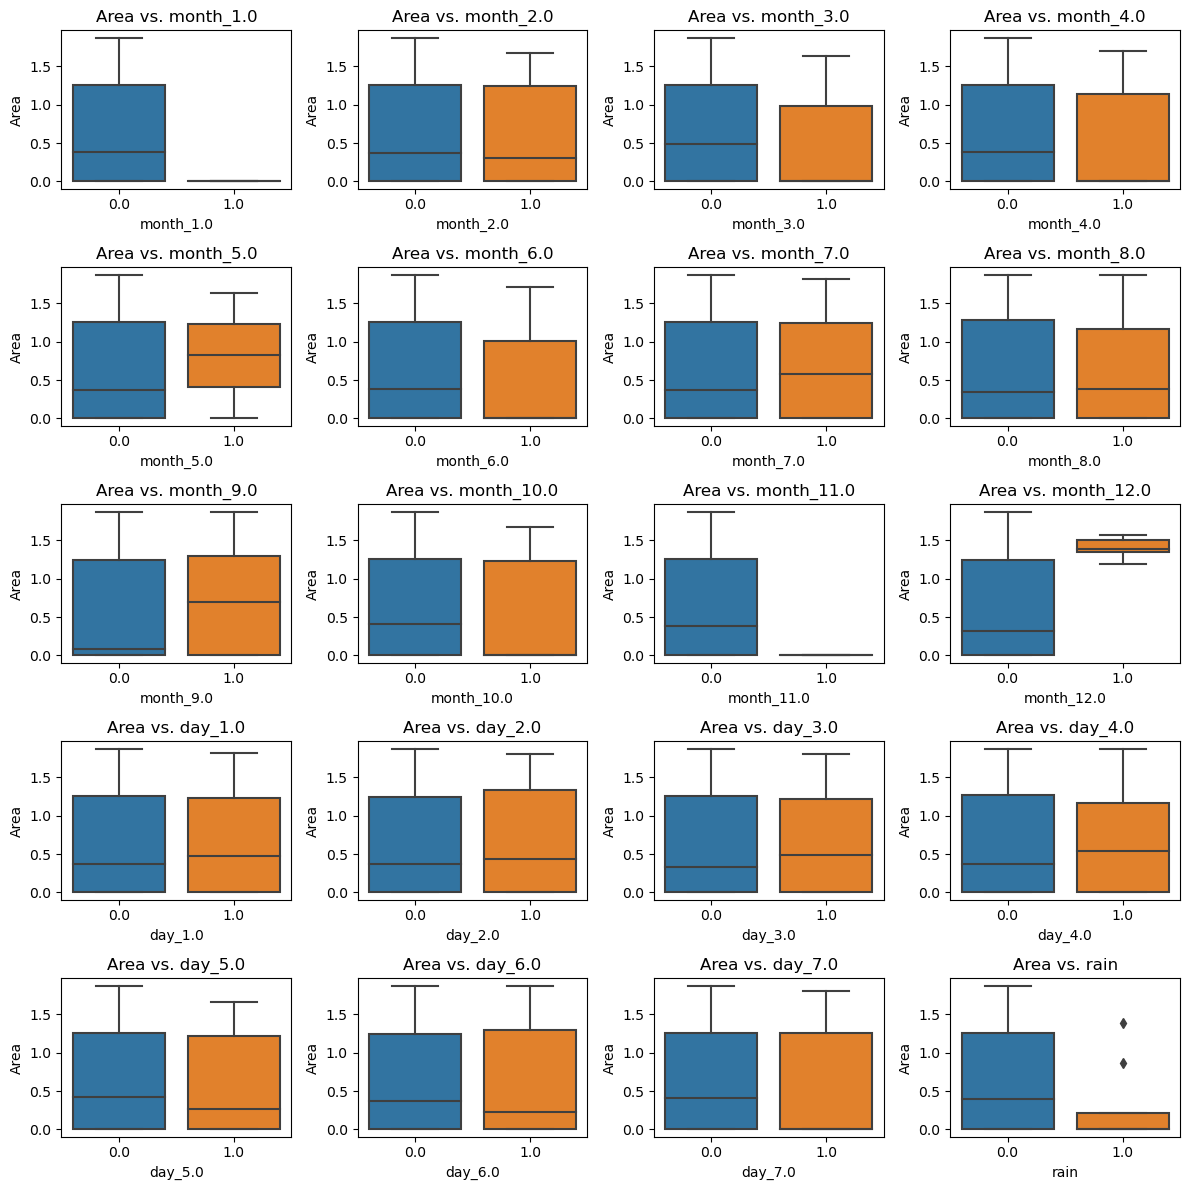

In [12]:
# Making the plot for categorical vars
plt.figure(figsize=(12, 12))

for i, var in enumerate(cat_vars, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(data=scaled_fires, x=var, y=area)
    plt.title(f'Area vs. {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Area')

plt.tight_layout()
plt.show()


While the month variable is predictive of the frequency of fires, it is less helpful in predicting the size of fires (the burnt area). January and November stand out as months with basically zero burnt area, while May on average saw on average more affected area. Particularly strange is the plot for December. This should be an unlikely season for wildfires to occur, but apparantly some instances of fires with large areas have been recorded. If the fit of our model should be affected, this might be a strong candidate to delete.

The day variable shows no differences regarding the size of affected areas. Previously we had observed a pattern of higher chances to see outbreaks on weekends, but this doesn't affect their size.

Lastly, we see that the affected areas on average is much smaller on rainy days, but there are two outliers of large area fires that occured during rainy days. These might be candidates for deletion too, in case our model is not performing well.

Let's take a look at the relationships bbetween area and the continuous variables.

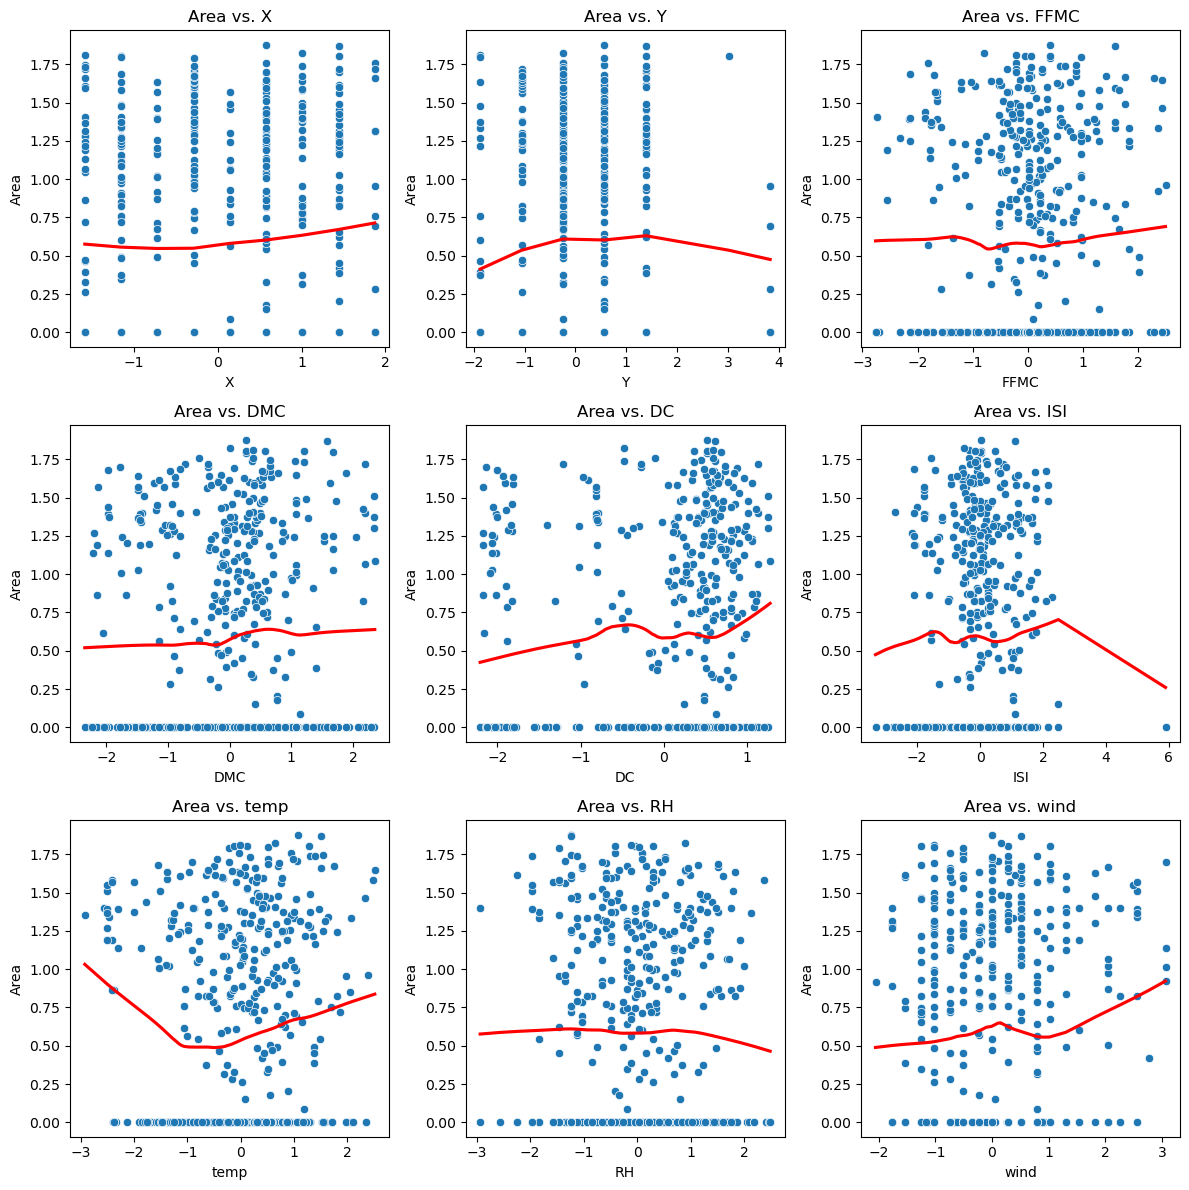

In [13]:
# Making the plot for continuous  vars
plt.figure(figsize=(12, 12))

for i, var in enumerate(cont_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=scaled_fires, x=var, y=area)
    sns.regplot(data=scaled_fires, x=var, y=area, lowess=True, scatter=False, color='red')
    plt.title(f'Area vs. {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Area')

plt.tight_layout()
plt.show()

What we can see in these plots is that the X and Y coordinates, treated as continuous variables, are not very predictive. There seems to be a tendency to have larger areas affected in the north, but the pattern for the Y variable is not clear. `FFMC`, `DC`, and `ISI` are moderately predicting larger affected areas. However, `ISI` has a stong unintuitive outlier, which we willl drop below. This is leading to a downward bias for higher ISI values. A good predictor seems to be `wind`, with strong winds predicting larger affected areas. `DMC`and `RH`both don't show a pronounced correlation with `area`. The temperature variable shows a U-shaped pattern, with more affected area in either low or high temperatures. In this regard, the previously observed outlying position of the December variable does not seem so special anymore, given that temperatures are usually low in December. (And there are plenty of large-area fires at low temperatures.)
Potential deletion candidates among the continuous predictors are `X` , `Y`, `DMC` and `RH`. `temperature`should probably be modelled with a quadtratic polynomial term.

In [14]:
# drop outlier in ISI
scaled_fires = scaled_fires[scaled_fires['ISI'] < 4]
area = scaled_fires['area']
scaled_fires = scaled_fires.drop(columns='area')

Let's double check the plots with the `ISI`outlier removed.

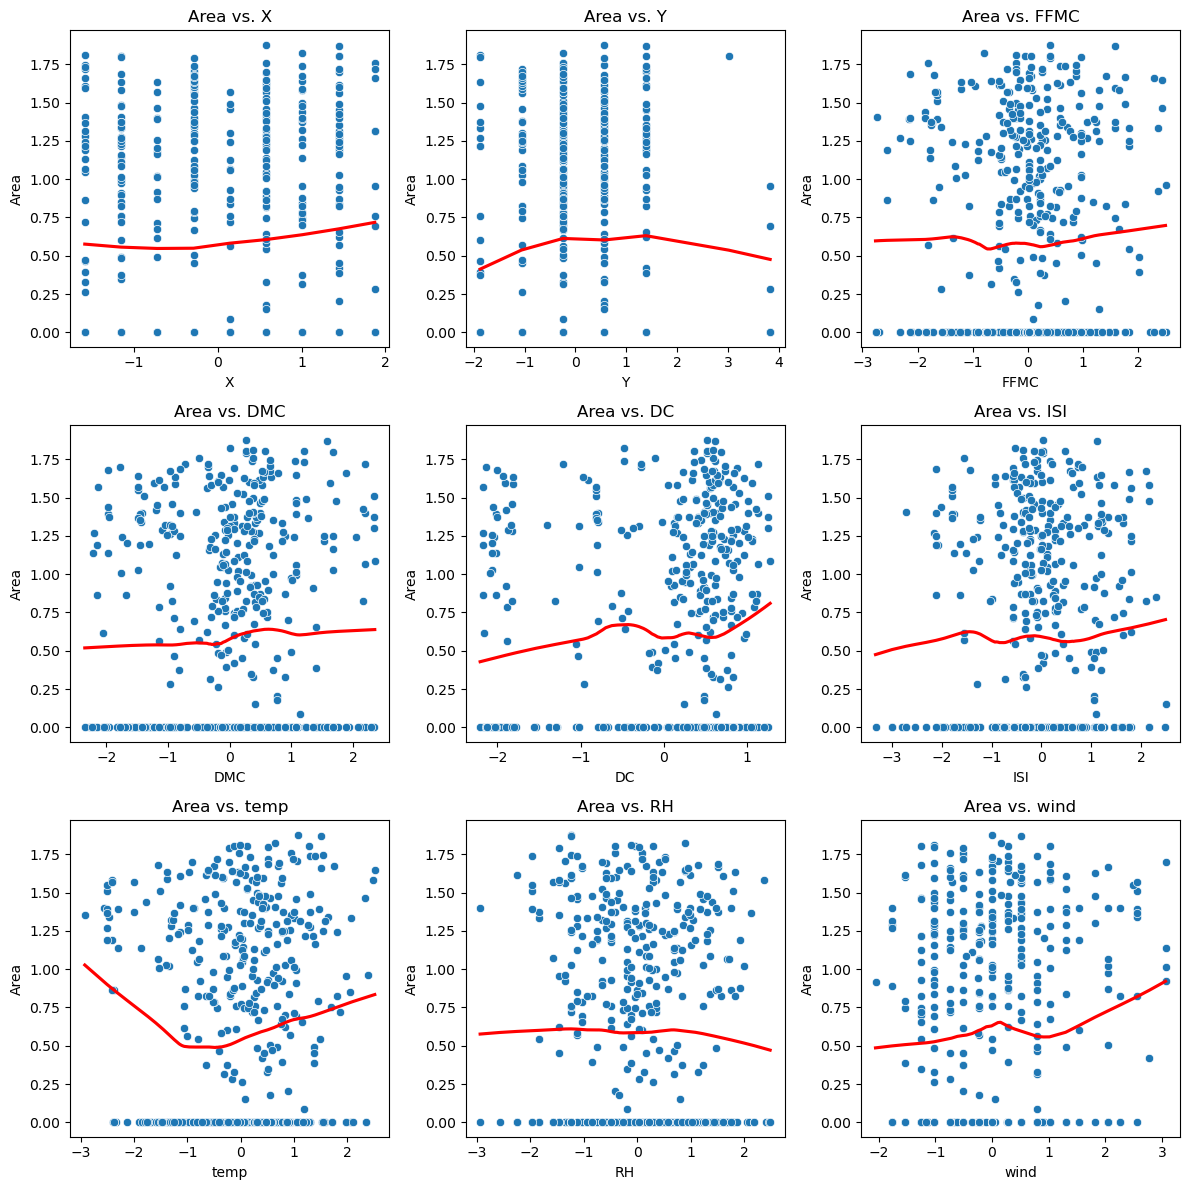

In [15]:
plt.figure(figsize=(12, 12))

for i, var in enumerate(cont_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=scaled_fires, x=var, y=area)
    sns.regplot(data=scaled_fires, x=var, y=area, lowess=True, scatter=False, color='red')
    plt.title(f'Area vs. {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Area')

plt.tight_layout()
plt.show()

## Instantiating the reference model

Our reference model will only use `temp` (temperature) and `wind` (wind strength) as predictors, while `area` (toal area damaged by fire) is the outcome of interest. Let's instantiate it and run it, so that we have a baseline to compare our models against.

In [16]:
# assigning training and test data
# we are dropping month_1.0 and day_7.0 as reference categories
X = scaled_fires.drop(columns=['month_1.0', 'day_7.0'])
y= area

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# training and test_data for the reference model
X_ref = scaled_fires[['temp', 'wind']]
y_ref = area

X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.2, random_state=23)

# instantiating reference model
ref_model = LinearRegression()
ref_model.fit(X_ref_train, y_ref_train)
ref_model_mse = mean_squared_error(ref_model.predict(X_ref_test), y_ref_test)
print("MSE reference model: ", ref_model_mse)

MSE reference model:  0.44911542412289585


In [17]:
# getting the coefficients
intercept = ref_model.intercept_
coefficients = ref_model.coef_

# creating a regression summary table
index = ['Intercept'] + X_ref.columns.tolist()
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=index)

print("Regression Table Reference Model")
print(regression_table)

Regression Table Reference Model
           Coefficient
Intercept     0.575564
temp          0.041634
wind          0.046324


As a comparison, let us try the linear model with all features.

In [18]:
# linear regression with all features
model2 = LinearRegression()
model2.fit(X_train, y_train)
model2_mse = mean_squared_error(model2.predict(X_test), y_test)
print("MSE Model 2: ", model2_mse)

MSE Model 2:  0.4424800034038068


In [19]:
# getting the coefficients
intercept = model2.intercept_
coefficients = model2.coef_

# creating a regression summary table
index = ['Intercept'] + X.columns.tolist()
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=index)

print("Regression Table Reference Model")
print(regression_table)

Regression Table Reference Model
            Coefficient
Intercept      0.377579
X             -0.010029
Y              0.016722
FFMC           0.049040
DMC            0.032141
DC             0.054044
ISI           -0.022754
temp           0.093218
RH             0.060716
wind           0.048172
month_2.0      0.604983
month_3.0      0.259179
month_4.0      0.284454
month_5.0      0.714381
month_6.0      0.217901
month_7.0      0.240653
month_8.0      0.062547
month_9.0      0.253639
month_10.0     0.064589
month_11.0    -0.018098
month_12.0     1.360007
day_1.0        0.014831
day_2.0        0.043090
day_3.0        0.063635
day_4.0       -0.007543
day_5.0       -0.070476
day_6.0       -0.007907
rain          -0.384355


If we compare the results from the reference model and the linear regression with all features, we find that the reference model using `temp`and `wind`as only predictors has a slightly higher error (`MSE=0.4491`) than the the model with all predictors (`MSE=0.4424`). But given that it only utilizes two predictors, it is a lot more parsimonious. Therefore, we should identify a subset of variables with reasonable predictive power which can improve the performance in comparison to the reference model. 

## Subset selection

We will use forward and backward selection (using simple linear regression) to identify a promising subset of predictor variables. Let's aim to reduce our current set of predictors by approximately half.

In [20]:
# We use a linear regression as feature selector, selecting 12 features

lm = LinearRegression()

sfs_forward = SequentialFeatureSelector(
    lm, n_features_to_select=12, direction="forward"
).fit(X, y)

sfs_backward = SequentialFeatureSelector(
    lm, n_features_to_select=12, direction="backward"
).fit(X, y)

print("Chosen features Forward Selection:", X_train.columns[sfs_forward.get_support()])
print("Chosen features Backward Selection:", X_train.columns[sfs_backward.get_support()])


Chosen features Forward Selection: Index(['X', 'FFMC', 'ISI', 'wind', 'month_3.0', 'month_7.0', 'month_8.0',
       'month_11.0', 'day_2.0', 'day_5.0', 'day_6.0', 'rain'],
      dtype='object')
Chosen features Backward Selection: Index(['X', 'FFMC', 'wind', 'month_3.0', 'month_6.0', 'month_7.0', 'month_8.0',
       'month_9.0', 'month_10.0', 'month_11.0', 'day_5.0', 'rain'],
      dtype='object')


Both approches agree in some variables and disagreee in others. `X`, `wind`, `FFMC` and `rain` are agreed upon, but there's disagreement about the `month` and `day` dummies. Let's try to code the months as seasons: December-February as winter, March-May as spring, June-September as summer, October-November as autumn. Let's also code Friday, Saturday and Sunday as weekend days. This is only partially overlapping with these results, but these cosings of seasonality and weekend activity makes sense if we think that the severity of fires is related at least partially to human factors. We then try our forward and backward selection again.

In [21]:
# recode seasonality and weekend variables
# seasons
scaled_fires['Winter'] = scaled_fires[['month_12.0', 'month_1.0', 'month_2.0']].any(axis=1).astype(int)
scaled_fires['Spring'] = scaled_fires[['month_3.0', 'month_4.0', 'month_5.0']].any(axis=1).astype(int)
scaled_fires['Summer'] = scaled_fires[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0']].any(axis=1).astype(int)
scaled_fires['Autumn'] = scaled_fires[['month_10.0', 'month_11.0']].any(axis=1).astype(int)

# weekend
scaled_fires['Weekend'] = scaled_fires[['day_5.0', 'day_6.0', 'day_7.0']].any(axis=1).astype(int)
scaled_fires['No_Weekend'] = (1 - scaled_fires['Weekend'])

# reduced dataframe, dropping old month and day variables and reference categories winter and no_weekend
X_reduced = scaled_fires.drop(columns=[f"month_{i}.0" for i in range(1, 13)] + [f"day_{i}.0" for i in range(1, 8)])
X_reduced = X_reduced.drop(columns=['Winter', 'No_Weekend'])

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_reduced, y, test_size=0.2, random_state=23)

In [22]:
# updated feature selection (select 8 features)

lm = LinearRegression()

sfs_forward = SequentialFeatureSelector(
    lm, n_features_to_select=8, direction="forward"
).fit(X_red_train, y_red_train)

sfs_backward = SequentialFeatureSelector(
    lm, n_features_to_select=8, direction="backward"
).fit(X_red_train, y_red_train)

print("Chosen features Forward Selection:", X_red_train.columns[sfs_forward.get_support()])
print("Chosen features Backward Selection:", X_red_train.columns[sfs_backward.get_support()])

Chosen features Forward Selection: Index(['FFMC', 'DC', 'temp', 'wind', 'Spring', 'Summer', 'Autumn', 'Weekend'], dtype='object')
Chosen features Backward Selection: Index(['DC', 'ISI', 'temp', 'wind', 'Spring', 'Summer', 'Autumn', 'Weekend'], dtype='object')


That looks like a lot more agreement. Let's retain the season and weekend variables, as well as `FFMC`, `DC`. `ISI`, `temp`, and `wind`.

In [23]:
# retain the slected variables
X_reduced = X_reduced[['FFMC', 'DC', 'ISI', 'temp', 'wind', 'Spring', 'Summer', 'Autumn', 'Weekend']]
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_reduced, y, test_size=0.2, random_state=23)

In [24]:
# fit an updated model
model_red = LinearRegression()
model_red.fit(X_red_train, y_red_train)
model_red_mse = mean_squared_error(model_red.predict(X_red_test), y_red_test)
print("MSE Reduced Model: ", model_red_mse)

MSE Reduced Model:  0.4447548724051436


This model has a better fit than the reference model with three predictors, but its fit does not surpass the full model. Let's compare the BIC of those three models.

In [25]:
# BIC calculation

def BIC(X, y, model):
    """Fits the Bayesian Information Criterion"""
    n = len(y)  # number of observations
    k = X.shape[1] + 1  # number of parameters (including intercept)
    rss = np.sum((y - model.predict(X)) ** 2) # RSS
    log_likelihood = -n / 2 * (np.log(2 * np.pi * rss / n) + 1) # log-likelihood
    bic = -2 * log_likelihood + k * np.log(n)
    return bic

print("BIC Reference Model:", BIC(X_ref_test, y_ref_test, ref_model))
print("BIC Full Model:", BIC(X_test, y_test, model2))
print("BIC Reduced Model:", BIC(X_red_test, y_red_test, model_red))

BIC Reference Model: 225.82295068810285
BIC Full Model: 340.38471949980294
BIC Reduced Model: 257.3189961978746


This is result shows that by reducing the number of predictors, we managed to improve the BIC compared to the full model. However, the reference model is still better at predicting the outomce with only two predictors. Let's see if we can improve the reduced model further by regularization and adding non-linear patterns.

## Regularization and non-linear models

After successfully reducing the predictors, let us now try to make the model even more parsimonious by applying a Lasso regression. In the next step, we will then try to fit some polynomial or spline fit to model non-linear relationships. For example we had observed that the temperature effect seemed to have a U-shape pattern.

In [26]:
# Lasso regression reference model
lasso_ref = LassoCV(alphas=np.linspace(0.001, 0.05, num=100))
lasso_ref.fit(X_ref_train, y_ref_train)
lasso_ref_coef = lasso_ref.coef_
best_ref_alpha = lasso_ref.alpha_
ref_intercept = lasso_ref.intercept_
lasso_ref_mse = mean_squared_error(y_ref_test, lasso_ref.predict(X_ref_test))

print("MSE Lasso Reference Model: ", lasso_ref_mse)
print("BIC Lasso Reference Model:", BIC(X_ref_test, y_ref_test, lasso_ref))

# Lasso regression full model
lasso_mod2 = LassoCV(alphas=np.linspace(0.001, 0.05, num=100))
lasso_mod2.fit(X_train, y_train)
lasso_mod2_coef = lasso_mod2.coef_
best_mod2_alpha = lasso_ref.alpha_
mod2_intercept = lasso_ref.intercept_
lasso_mod2_mse = mean_squared_error(y_test, lasso_mod2.predict(X_test))

print("MSE Lasso Full Model: ", lasso_ref_mse)
print("BIC Lasso Full Model:", BIC(X_ref_test, y_ref_test, lasso_ref))

# Lasso regression reduced model
lasso_red = LassoCV(alphas=np.linspace(0.001, 1, num=100))
lasso_red.fit(X_red_train, y_red_train)
lasso_red_coef = lasso_red.coef_
best_red_alpha = lasso_ref.alpha_
red_intercept = lasso_ref.intercept_
lasso_red_mse = mean_squared_error(y_red_test, lasso_red.predict(X_red_test))

print("MSE Lasso Reduced Model: ", lasso_red_mse)
print("BIC Lasso Reduced Model:", BIC(X_red_test, y_red_test, lasso_red))

MSE Lasso Reference Model:  0.45266229407573183
BIC Lasso Reference Model: 226.64106000669966
MSE Lasso Full Model:  0.45266229407573183
BIC Lasso Full Model: 226.64106000669966
MSE Lasso Reduced Model:  0.4452605528971224
BIC Lasso Reduced Model: 257.4371756705663


In [27]:
# create regression tables
ref_table = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_ref_train.columns),
    'Coefficient Ref': [ref_intercept] + list(lasso_ref_coef)
})

full_table = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient Full': [mod2_intercept] + list(lasso_mod2_coef)
})

red_table = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_red_train.columns),
    'Coefficient Red': [red_intercept] + list(lasso_red_coef)
})

# merge tables
regression_table = ref_table.merge(full_table, on='Feature', how='outer') \
                            .merge(red_table, on='Feature', how='outer')

regression_table

,Feature,Coefficient Ref,Coefficient Full,Coefficient Red
0,Intercept,0.576176,0.576176,0.576176
1,temp,0.000000,0.000000,0.027447
2,wind,0.000000,0.004582,0.053453
3,X,NaN,-0.000000,NaN
4,Y,NaN,0.000000,NaN
5,FFMC,NaN,0.000000,0.028790
6,DMC,NaN,0.000000,NaN
7,DC,NaN,0.024024,0.089108
8,ISI,NaN,0.000000,-0.031404
9,RH,NaN,-0.000000,NaN


The outcome from the Lasso regressions show that even a careful tuning of thr alpha parameters will regularize away many of the original features. The reference model only retains the intercept, the full model only retains small coefficients for `wind`and `DC`. The reduced model keeps most parameters, but also has a comparably lower fit. Let's see if non-linear parameters can help.

In [28]:
# cubic plines

test_mses_ref = []
for i in range(2, 11):
    spline_ref = SplineTransformer(degree=3, n_knots=i, knots="uniform")
    spline_X_ref_train = spline_ref.fit_transform(X_ref_train)
    spline_X_ref_test = spline_ref.transform(X_ref_test)
    model_ref = LinearRegression()
    model_ref.fit(spline_X_ref_train, y_ref_train)
    test_mses_ref.append(round(mean_squared_error(model_ref.predict(spline_X_ref_test), y_ref_test), 3))

print("MSEs Spline Reference Model: ", test_mses_ref)

test_mses_mod2 = []
for i in range(2, 11):
    spline_mod2 = SplineTransformer(degree=3, n_knots=i, knots="uniform")
    spline_X_mod2_train = spline_mod2.fit_transform(X_train)
    spline_X_mod2_test = spline_mod2.transform(X_test)
    model_mod2 = LinearRegression()
    model_mod2.fit(spline_X_mod2_train, y_train)
    test_mses_mod2.append(round(mean_squared_error(model_mod2.predict(spline_X_mod2_test), y_ref_test), 3))

print("MSEs Spline Full Model: ", test_mses_mod2)

test_mses_red = []
for i in range(2, 11):
    spline_red = SplineTransformer(degree=3, n_knots=i, knots="uniform")
    spline_X_red_train = spline_red.fit_transform(X_red_train)
    spline_X_red_test = spline_red.transform(X_red_test)
    model_red = LinearRegression()
    model_red.fit(spline_X_red_train, y_red_train)
    test_mses_red.append(round(mean_squared_error(model_red.predict(spline_X_red_test), y_red_test), 3))

print("MSEs Spline Reference Model: ", test_mses_red)

MSEs Spline Reference Model:  [0.436, 0.434, 0.433, 0.435, 0.432, 0.439, 0.416, 0.428, 0.426]
MSEs Spline Full Model:  [0.525, 0.519, 0.515, 6.474416457221228e+21, 8.286683823067915e+21, 2.862475790354595e+23, 1.0831447053197009e+25, 1.2564092116003096e+26, 2.427507294017791e+25]
MSEs Spline Reference Model:  [0.448, 0.446, 0.451, 0.458, 0.454, 0.448, 0.454, 0.463, 0.437]


Applying cubic splines will yield fairly different outcomes for our three candidate models. If we take the reference model, here we observe that a significant reduction in `MSE`can be achieved by applying cubic spline with 8 knots: `MSE=0.416`. Remember that the original `MSE`was 0.449.

For the full model, maybe not so surprising, applying cubic splines will eventually make the number of parameters explode and lead to a detoriating model fit. All observed `MSE`s are worse than before.

For the reduced model, a small impovement is possible. We find that applying the cubic spline with 10 knots will improve the MSE to 0.437, compared to 0.445.

This means that the spline model will generally improve the model fit more than the regularization implemented with the Lasso regression. As of now, the reference model with the 8 knots cubic splines will perform best, the reduced model with 10 knots, second best.

## K-Fold Cross-Validation

Let us now evaluate our two best models using K-Fold Cross-Validation. We will not consider the full model anymore.
We will perform a 5 and a 10-Fold Cross Validation for the reference model without splines, for the reference model with splines the reduced model without splines and with splines.

In [29]:
# Reference model without spline
ref_model_cv = LinearRegression()
ref_model_cv.fit(X_ref_train, y_ref_train)

# perform K-Fold Cross-Validation with 5 and 10 folds
k5_ref0 = cross_val_score(ref_model_cv, X_ref, y_ref, cv=5, scoring="neg_mean_squared_error")
k10_ref0 = cross_val_score(ref_model_cv, X_ref, y_ref, cv=10, scoring="neg_mean_squared_error")

# convert negative MSE to positive MSE
k5_ref0 = -k5_ref0
k10_ref0 = -k10_ref0

# averages and standard deviations
avgs_ref0 = [np.mean(k5_ref0), np.mean(k10_ref0)]
stds_ref0 = [np.std(k5_ref0), np.std(k10_ref0)]

print("5-Fold CV MSE (Ref no spline):", k5_ref0)
print("5-Fold CV Average (Ref no spline):", avgs_ref0[0])
print("5-Fold CV Std (Ref no spline):", stds_ref0[0])
print('\n')
print("10-Fold CV MSE (Ref no spline):", k10_ref0)
print("10-Fold CV Average (Ref no spline):", avgs_ref0[1])
print("10-Fold CV Std (Ref no spline):", stds_ref0[1])
print('\n')


# Reference model with spline

# define model pipeline
spline_model_ref_cv = make_pipeline(
    SplineTransformer(degree=3, n_knots=8, knots="uniform"),
    LinearRegression()
)

# perform K-Fold Cross-Validation with 5 and 10 folds
k5_ref = cross_val_score(spline_model_ref_cv, X_ref, y_ref, cv=5, scoring="neg_mean_squared_error")
k10_ref = cross_val_score(spline_model_ref_cv, X_ref, y_ref, cv=10, scoring="neg_mean_squared_error")

# convert negative MSE to positive MSE
k5_ref = -k5_ref
k10_ref = -k10_ref

# averages and standard deviations
avgs_ref = [np.mean(k5_ref), np.mean(k10_ref)]
stds_ref = [np.std(k5_ref), np.std(k10_ref)]

print("5-Fold CV MSE (Ref w spline):", k5_ref)
print("5-Fold CV Average (Ref w spline):", avgs_ref[0])
print("5-Fold CV Std (Ref w spline):", stds_ref[0])
print('\n')
print("10-Fold CV MSE (Ref w spline):", k10_ref)
print("10-Fold CV Average (Ref w spline):", avgs_ref[1])
print("10-Fold CV Std (Ref w spline):", stds_ref[1])
print('\n')

# Reduced model without spline
model_red = LinearRegression()
model_red.fit(X_red_train, y_red_train)

# perform K-Fold Cross-Validation with 5 and 10 folds
k5_red0 = cross_val_score(model_red, X_reduced, y, cv=5, scoring="neg_mean_squared_error")
k10_red0 = cross_val_score(model_red, X_reduced, y, cv=10, scoring="neg_mean_squared_error")

# convert negative MSE to positive MSE
k5_red0 = -k5_red0
k10_red0 = -k10_red0

# averages and standard deviations
avgs_red0 = [np.mean(k5_red0), np.mean(k10_red0)]
stds_red0 = [np.std(k5_red0), np.std(k10_red0)]

print("5-Fold CV MSE (Red no spline):", k5_red0)
print("5-Fold CV Average (Red no spline):", avgs_red0[0])
print("5-Fold CV Std (Red no spline):", stds_red0[0])
print('\n')
print("10-Fold CV MSE (Red no spline):", k10_red0)
print("10-Fold CV Average (Red no spline):", avgs_red0[1])
print("10-Fold CV Std (Red no spline):", stds_red0[1])
print('\n')


# Reduced model with spline

# define model pipeline
spline_model_red_cv = make_pipeline(
    SplineTransformer(degree=3, n_knots=10, knots="uniform"),
    LinearRegression()
)

# perform K-Fold Cross-Validation with 5 and 10 folds
k5_red = cross_val_score(spline_model_red_cv, X_reduced, y, cv=5, scoring="neg_mean_squared_error")
k10_red = cross_val_score(spline_model_red_cv, X_reduced, y, cv=10, scoring="neg_mean_squared_error")

# convert negative MSE to positive MSE
k5_red = -k5_red
k10_red = -k10_red

# averages and standard deviations
avgs_red = [np.mean(k5_red), np.mean(k10_red)]
stds_red = [np.std(k5_red), np.std(k10_red)]

print("5-Fold CV MSE (Red w spline):", k5_red)
print("5-Fold CV Average (Red w spline):", avgs_red[0])
print("5-Fold CV Std (Red w spline):", stds_red[0])
print('\n')
print("10-Fold CV MSE (Red w spline):", k10_red)
print("10-Fold CV Average (Red w spline):", avgs_red[1])
print("10-Fold CV Std (Red w spline):", stds_red[1])

5-Fold CV MSE (Ref no spline): [0.59001307 0.31786775 0.67641729 0.44505658 0.43495306]
5-Fold CV Average (Ref no spline): 0.49286154988143743
5-Fold CV Std (Ref no spline): 0.12601004925784068


10-Fold CV MSE (Ref no spline): [0.46648127 0.45767859 0.28093311 0.47621452 0.85412445 0.42377312
 0.33771384 0.52577494 0.37749414 0.48299604]
10-Fold CV Average (Ref no spline): 0.468318400300842
10-Fold CV Std (Ref no spline): 0.14661038628889844


5-Fold CV MSE (Ref w spline): [0.56192193 0.31813392 0.66130837 0.49912975 0.43811721]
5-Fold CV Average (Ref w spline): 0.49572223764303447
5-Fold CV Std (Ref w spline): 0.11547183778470868


10-Fold CV MSE (Ref w spline): [0.42058798 0.45262827 0.24347521 0.5222366  0.92857147 0.35211407
 0.3540041  0.61405832 0.32710995 0.62167713]
10-Fold CV Average (Ref w spline): 0.48364630946061615
10-Fold CV Std (Ref w spline): 0.18887548610857938


5-Fold CV MSE (Red no spline): [0.58708429 0.32384735 0.64333372 0.44650365 0.4940465 ]
5-Fold CV Average 

Examining the average MSEs and their standard deviations, the best performing model is the linear reference model, which only includes the predictors `temp` and `wind`. It has an average MSE of 0.49 with 0.13 standard deviation for the 5-fold Cross Validation. The 10-fold CV improves the mean to 0.47 at a cost of higher Std (0.15). Adding the splines will not improve the model fit of the reference model.

In comparison, the reduced model is not improving on the model fit by including more predictors. Both for the 5 and 10-fold case the MSEs are slightly higher (0.50, 0.48) with higher Stds. Adding the splines here will lead to much worse MSEs (0.66, 0.60), indicating substantial overfitting.

Therefore, the simple linear reference model is still the best performing model based on the Cross Validation results.

## Examining model weaknesses

Now that we've created many candidate models, we can choose the best and start to determine where our data might be lacking. To do this, we need to visualize how the model predictions compare against the actual observed values in the data. It may be the case that our model performs well on a particular subset of outcomes but poorly on another subset. The only way to know this is to visualize these differences. 

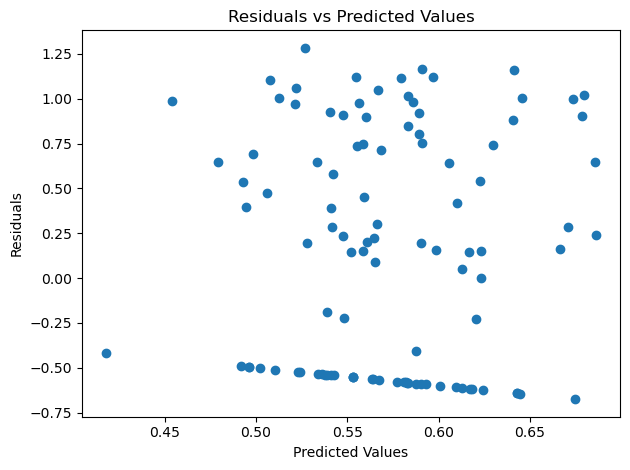

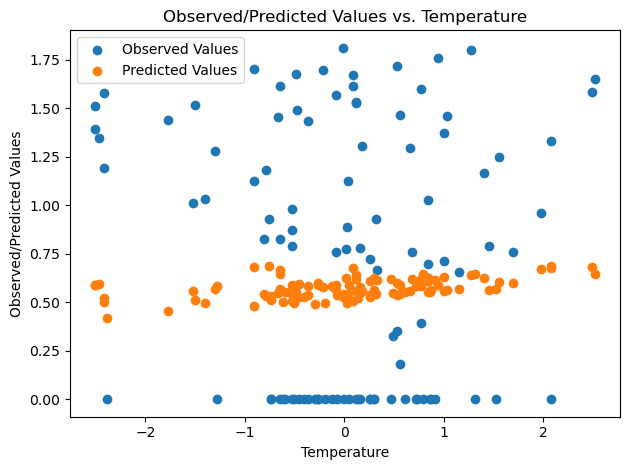

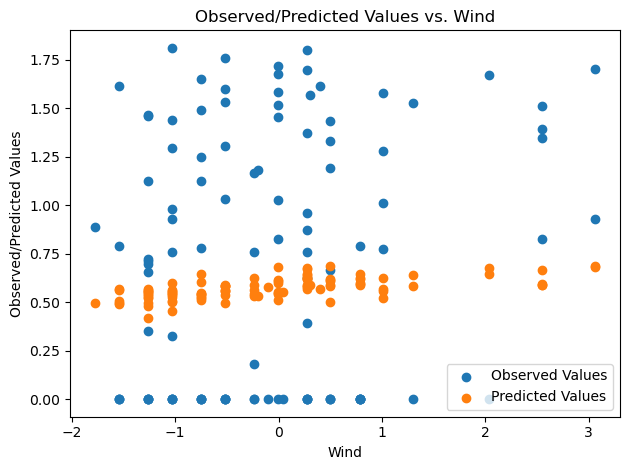

In [31]:
# predictions from the simple linear model
y_predict = ref_model_cv.predict(X_ref_test)
residuals = y_ref_test - y_predict

# Residuals vs Predicted Values Plot
plt.scatter(x=y_predict, y=residuals)
plt.title('Residuals vs Predicted Values', fontsize=12)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# temp vs. observed values, temp vs. predicted values
plt.scatter(x=X_ref_test['temp'], y=y_ref_test, label='Observed Values')
plt.scatter(x=X_ref_test['temp'], y=y_predict, label='Predicted Values')
plt.title('Observed/Predicted Values vs. Temperature', fontsize=12)
plt.xlabel('Temperature')
plt.ylabel('Observed/Predicted Values')

plt.legend()
plt.tight_layout()
plt.show()

# wind vs. observed values, wind vs. predicted values
plt.scatter(x=X_ref_test['wind'], y=y_ref_test, label='Observed Values')
plt.scatter(x=X_ref_test['wind'], y=y_predict, label='Predicted Values')
plt.title('Observed/Predicted Values vs. Wind', fontsize=12)
plt.xlabel('Wind')
plt.ylabel('Observed/Predicted Values')

plt.legend()
plt.tight_layout()
plt.show()

While the simple reference model achieves the lowest MSE overall, it is still not a very good model, as these plots show. The Residuals vs. Predicted Values Plot shows that it is not very good at predicting the 0 values of the area variable, as the lined-up observations at the bottom show. These are all observed zeros, for which the model predicts some positive area. Unfortunately the model is als not very good at predicting the more extreme cases. The cloud of observations above shows cases where the model underpredicted the affected area.

Looking at the Temperature vs. Observed/Predicted Values Plot, we see that the predictions are all in a faisly narrow band and misses the higher and lower (zero) instances. The same is true for the plot that shows the same relationships for wind.
In both cases, the model gets the tendency right, but fails to predict a broader range of actually observed affected areas.

It might help to break down the outocme variable into different classes, i.e. no area damage, vs. different categories of damagage and model the outcome as a multiple classification problem rather than a linear refression problem.